In [9]:
import sys
sys.path.append('/home/jhernandez/Work//')
sys.path.append('/home/jhernandez/Work/python_tools/')

from defaults import *
from tqdm import tqdm

from scipy.interpolate import griddata
from scipy import interpolate

import seawater as sw

In [3]:
simulations = {"CR": F"//mnt/vinson/DATA/modelling/WMOP_REANALYSIS/Outputs/EUROSEA_T4_FreeRun/forecast_scratch/",
               "noGLI": F"/mnt/vinson/DATA/modelling/WMOP_REANALYSIS/Outputs/EUROSEA_T4_noGLIDERS/forecast_scratch/",
               "GLI": F"/mnt/vinson/DATA/modelling/WMOP_REANALYSIS/Outputs/EUROSEA_T4_GLIDERS/forecast_scratch/"
              }

## Analyze Transports through Ibiza Channel

In [4]:
import pyroms

file_wmop = '/home/modelling/data/WMOP/WMOP_REANALYSIS/Outputs/EUROSEA_T4_GLIDERS/forecast_scratch/roms_WMOP_FORECAST_20170925_avg.nc'
grd = pyroms.grid.get_ROMS_grid('wmop', hist_file=file_wmop, grid_file=file_wmop)
z_w = grd.vgrid.z_w[:]
z_r = grd.vgrid.z_r[:]

Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file


In [5]:
from tqdm import tqdm

### Model Transports across IC

In [10]:
# Define Section location
lon_min = 0.1
lon_max = 1.1
lat_min = 39.0

nlon_min = np.argmin(np.abs(grd.hgrid.lon[0,:] - lon_min))
nlon_max = np.argmin(np.abs(grd.hgrid.lon[0,:] - lon_max))
nlat_min = np.argmin(np.abs(grd.hgrid.lat[:,0] - lat_min))

# Get Depths from section
z_section = z_r[:,nlat_min, nlon_min:nlon_max]
z_section_diff = np.diff(z_w[:,nlat_min, nlon_min:nlon_max], axis=0)

lon_section = grd.hgrid.lon[nlat_min, nlon_min:nlon_max]
dist_x = sw.dist(lat_min, lon_section)[0]

v_section = {}
transport_section = {}
transport_serie = {}

for sim in simulations:
    
    files_period = glob(F"{simulations[sim]}*2017*avg*")
    files_period.sort()
    # files_period = files_period[3:-5]
    
    transport_serie[sim] = []
    
    for file in tqdm(files_period):
        # Load file for October 2017 
        ds_wmop = xr.open_dataset(file)

        # Get velocity in Section
        v_section[sim] = ds_wmop.v[0,:,nlat_min, nlon_min:nlon_max].values
        # Calculate transport in Section
        transport_section[sim] = z_section_diff * dist_x[0] * 1000 * v_section[sim] / 1e6

        transport_serie[sim].append(np.nansum(transport_section[sim]) )

    print(F"Mean transport across IC section October 2017 for {sim} = {np.nanmean(transport_serie[sim]):0.2f} Sv")


100%|██████████| 364/364 [01:38<00:00,  3.70it/s]


Mean transport across IC section October 2017 for CR = 0.05 Sv


100%|██████████| 365/365 [01:27<00:00,  4.18it/s]


Mean transport across IC section October 2017 for noGLI = 0.39 Sv


100%|██████████| 364/364 [01:39<00:00,  3.67it/s]

Mean transport across IC section October 2017 for GLI = 0.10 Sv


In [7]:
date_ini = datetime(2017,1,1)
dates_transport = [date_ini + timedelta(days=i) for i in range(len(files_period))]

### Glider transports (from obs)

In [8]:
import scipy.io as sio

glider_transport_files = {}
glider_transport_files['baptiste'] = glob('/mnt/waverider/data/Data/Observations/GLIDERS/Canales_Ibiza_Channel/Canales_processed_Baptiste_Nov2020/*/*transports_channel.mat')
glider_transport_files['melanie'] = glob('/LOCALDATA/Data/Glider_transports_IC/Melanie/*')

df_allyear = {}

for p in glider_transport_files.keys():
    
    df_allyear[p] = pd.DataFrame(columns=['AWo', 'AWr', 'LIW', 'WIW', 'WDW', 'AWo', 'AWr', 'LIW', 'WIW', 'WDW',
           'Tot-N', 'Tot-S'])

    for file in glider_transport_files[p]:

        # print(file.split('/')[-2])#.split('_')[1])
        # print(file.split('/')[-1].split('_')[1])
        glider_transport = sio.loadmat(file)
        # mat = loadmat('measured_data.mat')  # load mat-file
        mdata =  glider_transport['transports']  # variable in mat file
        mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
        # * SciPy reads in structures as structured NumPy arrays of dtype object
        # * The size of the array is the size of the structure array, not the number
        #   elements in any particular field. The shape defaults to 2-dimensional.
        # * For convenience make a dictionary of the data using the names from dtypes
        # * Since the structure has only one element, but is 2-D, index it at [0, 0]
        ndata = {n: mdata[n][0, 0] for n in mdtype.names}
        # Reconstruct the columns of the data table from just the time series

        waterindex = [a[0] for a in ndata['waterIndex'][0] ]
        date = ndata['date']
        date_ind = [pd.to_datetime(date[i][0]-719529, unit='D') for i in range(date.shape[0])]

        df_wmass = pd.DataFrame(ndata['water'], columns=waterindex, index=date_ind)
        df_wtot = pd.DataFrame(ndata['total'], columns=['Tot-N', 'Tot-S'], index=date_ind)

        df = pd.concat([df_wmass,df_wtot], axis=1, join="inner")

        df_allyear[p] = pd.concat([df_allyear[p], df])

### Plot WMOP and Glider transports 

In [18]:
for sim in simulations:
    print(sim)
    print(len(transport_serie[sim]))

CR
364
noGLI
365
GLI
364


In [19]:
transport_serie['noGLI'] = transport_serie['noGLI'][:-1]

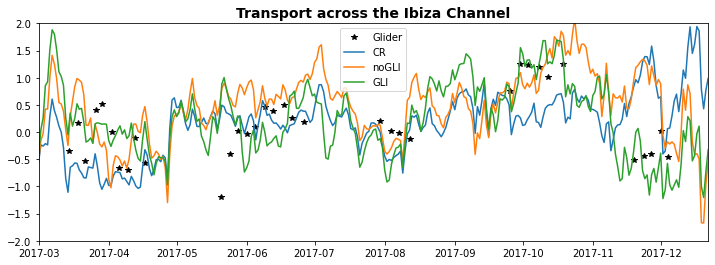

In [20]:
fig_transport = plt.figure(figsize=(12,4))
plt.plot(df_allyear['baptiste']['Tot-N'] + df_allyear['baptiste']['Tot-S'], 'k*', label='Glider')
# plt.plot(df_allyear['melanie']['Tot-N'] + df_allyear['melanie']['Tot-S'], 'r*', label='Glider M')
# plt.plot(df['Tot-N'] - df['Tot-S'], 'k*', label='Glider')
for sim in simulations:
    plt.plot(dates_transport, transport_serie[sim], label=sim)
    
plt.legend()
plt.title('Transport across the Ibiza Channel', fontsize=14, fontweight='bold')
plt.xlim((datetime(2017,3,1), datetime(2017,12,22)))
plt.ylim((-2,2))
plt.grid()


plt.show()

In [21]:
fig_transport.savefig(F'/LOCALDATA/Plots/EuroSea/WP4/mean_transport_Eurosea_reanalysis_Canales_2017.png', 
                         dpi=250, transparent=False, facecolor="w")

### Plot WMOP and Glider transports (filtered)

In [1]:
from scipy.ndimage import uniform_filter1d



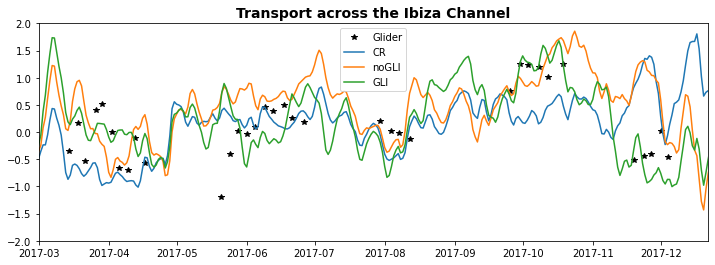

In [23]:
fig_transport = plt.figure(figsize=(12,4))
plt.plot(df_allyear['baptiste']['Tot-N'] + df_allyear['baptiste']['Tot-S'], 'k*', label='Glider')
# plt.plot(df_allyear['melanie']['Tot-N'] + df_allyear['melanie']['Tot-S'], 'r*', label='Glider M')
# plt.plot(df['Tot-N'] - df['Tot-S'], 'k*', label='Glider')
for sim in simulations:
    
    transport_filtered = uniform_filter1d(transport_serie[sim], 3)
    plt.plot(dates_transport, transport_filtered, label=sim)
    
plt.legend()
plt.title('Transport across the Ibiza Channel', fontsize=14, fontweight='bold')
plt.xlim((datetime(2017,3,1), datetime(2017,12,22)))
plt.ylim((-2,2))


plt.show()


In [24]:
fig_transport.savefig(F'/LOCALDATA/Plots/EuroSea/WP4/mean_transport_Eurosea_reanalysis_Canales_2017_filtered.png', 
                         dpi=250, transparent=False, facecolor="w")

In [18]:

def get_water_mass_index(transp_section, t_section, s_section):
    # Transports by water mass 
    # Index WIW < 13 deg (Lopez-Jurado et al, 2008; Pinot & Ganachaud, 1999; Pinot et al, 2002)    
    water    = ['AWo','AWr','LIW', 'WIW', 'WDW']
    k = {}

    year = 2017
    limT = 13
    if year >= 2015:
        limT=13.15

    k['AWo'] = (t_section >= limT) & (s_section < 38.35) & (s_section >= 37.5)
    k['AWr'] = (t_section >= limT) & (s_section < 37.5)
    k['LIW'] = (t_section >= limT) & (s_section >= 38.35)
    k['WIW'] = (t_section <  limT) & (s_section <= 38.45)
    k['WDW'] = (t_section < limT) & (s_section > 38.45)

    k['p'] = transp_section > 0.0
    k['n'] = transp_section < 0.0

    return k


In [28]:
print(F"Total Transport = {np.nansum(transport_section[sim]):0.02f}")
t  = 0
for w in water:
    print(F"{w} Transport = {np.nansum(transport_section[sim][k[w]]):0.02f}")
    t = t + np.nansum(transport_section[sim][k[w]])
    
print(F"{t:0.02f}")
print()

Total Transport = 0.82
AWo Transport = 0.34
AWr Transport = 0.39
LIW Transport = 0.25
WIW Transport = -0.32
WDW Transport = 0.17
0.82



In [ ]:
print(F"Total Transport SOUTH= {np.nansum(transport_section[sim][k['p']])}")
print(F"Total Transport NORTH= {np.nansum(transport_section[sim][k['n']])}")

### Transport by Water Masses

In [20]:
water    = ['AWo','AWr','LIW', 'WIW', 'WDW']

In [22]:
from collections import defaultdict

# Define Section location
lon_min = 0.1
lon_max = 1.1
lat_min = 39.0

nlon_min = np.argmin(np.abs(grd.hgrid.lon[0,:] - lon_min))
nlon_max = np.argmin(np.abs(grd.hgrid.lon[0,:] - lon_max))
nlat_min = np.argmin(np.abs(grd.hgrid.lat[:,0] - lat_min))

# Get Depths from section
z_section = z_r[:,nlat_min, nlon_min:nlon_max]
z_section_diff = np.diff(z_w[:,nlat_min, nlon_min:nlon_max], axis=0)

lon_section = grd.hgrid.lon[nlat_min, nlon_min:nlon_max]
dist_x = sw.dist(lat_min, lon_section)[0]

v_section = {}
transport_section = {}
transport_serie = {}

for sim in simulations:
    
    files_period = glob(F"{simulations[sim]}*2017*avg*")
    files_period.sort()
    # files_period = files_period[3:-5]
    
    transport_serie[sim] = defaultdict(list)
    
    for file in tqdm(files_period):
        # Load file for October 2017 
        ds_wmop = xr.open_dataset(file)

        # Get velocity in Section
        v_section[sim] = ds_wmop.v[0,:,nlat_min, nlon_min:nlon_max].values
        # Calculate transport in Section
        transport_section[sim] = z_section_diff * dist_x[0] * 1000 * v_section[sim] / 1e6
        
        # Get Water Mass transport
        t_section = ds_wmop.temp[0,:,nlat_min, nlon_min:nlon_max].values
        s_section = ds_wmop.salt[0,:,nlat_min, nlon_min:nlon_max].values
        k = get_water_mass_index(transport_section[sim], t_section, s_section)

        transport_serie[sim]['total'].append( np.nansum(transport_section[sim]) )
        transport_serie[sim]['north'].append( np.nansum(transport_section[sim][k['p']]) )
        transport_serie[sim]['south'].append( np.nansum(transport_section[sim][k['n']]) )
        
        for w in water:
            transport_serie[sim][w + '-N'].append( np.nansum(transport_section[sim][(k[w]) & (k['p'])]) )
            transport_serie[sim][w + '-S'].append( np.nansum(transport_section[sim][(k[w]) & (k['n'])]) )

    print(F"Mean transport across IC section October 2017 for {sim} = {np.nanmean(transport_serie[sim]['total']):0.2f} Sv")


  0%|          | 0/365 [00:00<?, ?it/s]

Mean transport across IC section October 2017 for CR = 0.05 Sv


  0%|          | 0/364 [00:00<?, ?it/s]

Mean transport across IC section October 2017 for noGLI = 0.39 Sv


100%|██████████| 364/364 [03:09<00:00,  1.92it/s]

Mean transport across IC section October 2017 for GLI = 0.10 Sv


In [116]:
pd.DataFrame.from_dict(transport_serie['GLI']).sum(axis=0)

total     35.593222
north    462.776168
south   -427.182946
AWo-N    168.804015
AWo-S   -128.720640
AWr-N     99.553038
AWr-S    -14.237742
LIW-N    140.824605
LIW-S   -185.553997
WIW-N      4.957645
WIW-S    -17.045521
WDW-N     48.636866
WDW-S    -81.625047
dtype: float64

In [201]:
dates_files = [datetime(2017,1,1) + timedelta(days=i) for i in range(len(files_period))]

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('wmop_reanalysis_transports.xlsx', 
                        engine='xlsxwriter', datetime_format='yyyy-mm-dd')

for sim in simulations:
    df_transport = pd.DataFrame.from_dict(transport_serie[sim])
    if sim=='noGLI':
        df_transport.drop(index=df_transport.index[-1],axis=0,inplace=True)
        
    df_transport['dates'] = dates_files
    df_transport = df_transport.set_index('dates')
    df_transport.index = df_transport.index.strftime('%m/%d/%Y, %r')
    
    # Write each dataframe to a different worksheet.
    df_transport.to_excel(writer, sheet_name=sim)
        
# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [91]:
print(df_allyear['baptiste'].sum(axis=0)[0:-2].sum())
print(df_allyear['baptiste'].sum(axis=0)[0:5].sum())
print(df_allyear['baptiste'].sum(axis=0)[5:10].sum())
print(df_allyear['baptiste'].sum(axis=0)[-2:].sum())
df_allyear['baptiste'].sum(axis=0)

3.4045630962569646
24.682650262021316
-21.278087165764347
3.4044834434145272


AWo      12.440422
AWr       6.337453
LIW       5.648656
WIW       0.248580
WDW       0.007539
AWo     -11.410391
AWr      -1.391619
LIW      -7.226261
WIW      -1.245867
WDW      -0.003949
Tot-N    24.682650
Tot-S   -21.278167
dtype: float64

In [188]:
df_allyear['baptiste'].to_excel('glider_transports_ibiza_channel.xlsx', engine='xlsxwriter')

In [198]:
df_save = df_allyear['baptiste'].copy()
df_save.index = df_save.index.strftime('%m/%d/%Y, %r')
df_save.to_excel('glider_transports_ibiza_channel_baptiste.xlsx', engine='xlsxwriter')